In [312]:
import pandas as pd
from urllib.request import urlopen  
import os.path as osp
import os
import logging
import zipfile
from glob import glob
logging.getLogger().setLevel('INFO')
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sklearn import preprocessing
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

## Helpers

In [3]:
def download_file(url_str, path):
    url = urlopen(url_str)
    output = open(path, 'wb')       
    output.write(url.read())
    output.close()  
    
def extract_file(archive_path, target_dir):
    zip_file = zipfile.ZipFile(archive_path, 'r')
    zip_file.extractall(target_dir)
    zip_file.close()

## Download the dataset

In [5]:
BASE_URL = 'http://tennis-data.co.uk'
DATA_DIR = "tennis_data"
ATP_DIR = './{}/ATP'.format(DATA_DIR)
WTA_DIR = './{}/WTA'.format(DATA_DIR)

ATP_URLS = [BASE_URL + "/%i/%i.zip" % (i,i) for i in range(2000,2019)]
WTA_URLS = [BASE_URL + "/%iw/%i.zip" % (i,i) for i in range(2007,2019)]

os.makedirs(osp.join(ATP_DIR, 'archives'), exist_ok=True)
os.makedirs(osp.join(WTA_DIR, 'archives'), exist_ok=True)

# for files, directory in ((ATP_URLS, ATP_DIR), (WTA_URLS, WTA_DIR)):
#     for dl_path in files:
#         logging.info("downloading & extracting file %s", dl_path)
#         archive_path = osp.join(directory, 'archives', osp.basename(dl_path))
#         download_file(dl_path, archive_path)
#         extract_file(archive_path, directory)
    
ATP_FILES = sorted(glob("%s/*.xls*" % ATP_DIR))
WTA_FILES = sorted(glob("%s/*.xls*" % WTA_DIR))

df_atp = pd.concat([pd.read_excel(f) for f in ATP_FILES], ignore_index=True,sort=False)
df_wta = pd.concat([pd.read_excel(f) for f in WTA_FILES], ignore_index=True,sort=False)

logging.info("%i matches ATP in df_atp", df_atp.shape[0])
logging.info("%i matches WTA in df_wta", df_wta.shape[0])

INFO:root:52298 matches ATP in df_atp
INFO:root:29581 matches WTA in df_wta


## Your work

## Questions

### 1. Who are the three ATP players with the most wins ?

In [6]:
df_atp['Winner'].value_counts().head(3)

Federer R.     1121
Nadal R.        891
Djokovic N.     802
Name: Winner, dtype: int64

### 2. How many sets did the player “Federer R.” win in total ? 

In [23]:
#Take loser into account to count the sets that Federer won but lost the game

federer_sets = df_atp.loc[(df_atp['Winner']=='Federer R.') | (df_atp['Loser'] == 'Federer R.')] 
federer_sets['Wsets'].value_counts().sum() + federer_sets['Lsets'].value_counts().sum()

0

### 3. How many sets did the player “Federer R.” win during the years 2016 and 2017 ?

In [19]:
federer_2016_17 = federer_sets.loc[(federer_sets['Date'].dt.year == 2016) | (federer_sets['Date'].dt.year == 2017)]
federer_2016_17['Wsets'].value_counts().sum() + federer_2016_17['Lsets'].value_counts().sum()

170

### 4. For each match, what is the percentage of victories of the winner in the past ?

In [219]:
def all_victory_percentages(player_name):
    player_record = df_atp.loc[(df_atp['Winner'] == player_name) | (df_atp['Loser'] == player_name)]
    player_record = player_record.filter(['ATP', 'Date', 'Winner', 'Loser'])
    all_victory_percentages = list()

    for index, row in player_record.iterrows():
        player_latest_victories = player_record.loc[(player_record['Winner'] == player_name) &
                                              (player_record['Date']<row.Date)]
        
        games_played_till_now = player_record.loc[player_record['Date']<row.Date]
        
        current_victory_percentage = (player_latest_victories.ATP.count() /games_played_till_now.ATP.count()) * 100
        all_victory_percentages.append(current_victory_percentage)
    
    return all_victory_percentages

In [220]:
fed_perc = all_victory_percentages('Federer R.')
fed_perc

/home/devendra/myinstallations/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':


[nan,
 nan,
 50.0,
 33.33333333333333,
 33.33333333333333,
 33.33333333333333,
 50.0,
 50.0,
 50.0,
 50.0,
 50.0,
 63.63636363636363,
 63.63636363636363,
 63.63636363636363,
 64.28571428571429,
 64.28571428571429,
 64.28571428571429,
 64.28571428571429,
 66.66666666666666,
 66.66666666666666,
 65.0,
 61.904761904761905,
 59.09090909090909,
 56.52173913043478,
 54.166666666666664,
 52.0,
 52.0,
 52.0,
 52.0,
 55.172413793103445,
 55.172413793103445,
 55.172413793103445,
 56.25,
 54.54545454545454,
 52.94117647058824,
 51.42857142857142,
 50.0,
 48.64864864864865,
 47.368421052631575,
 47.368421052631575,
 47.368421052631575,
 48.78048780487805,
 48.78048780487805,
 48.78048780487805,
 48.78048780487805,
 51.11111111111111,
 51.11111111111111,
 51.11111111111111,
 51.11111111111111,
 51.11111111111111,
 54.0,
 54.0,
 53.84615384615385,
 53.84615384615385,
 53.70370370370371,
 52.72727272727272,
 52.72727272727272,
 52.63157894736842,
 52.63157894736842,
 52.63157894736842,
 53.3333333333

### Let's Plot it....

<IPython.core.display.Javascript object>


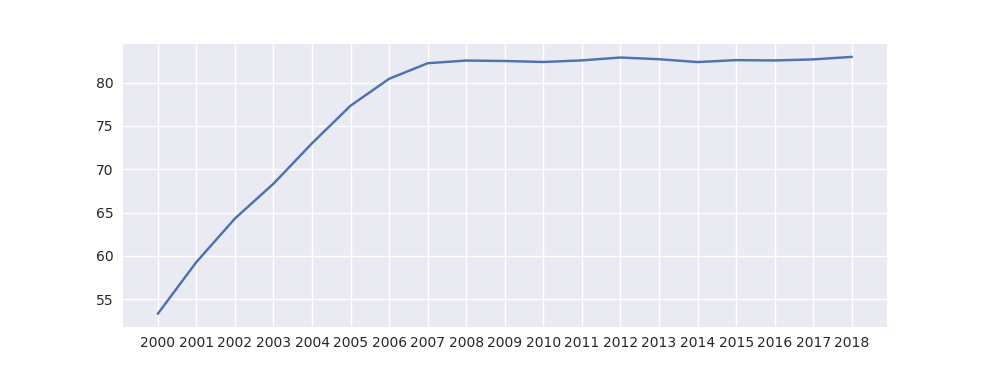

In [217]:
%matplotlib notebook

#create a separate dataframe for plotting by taking year-wise average of previous victory percentages 
plot_data = player_record

plot_data['Year'] = player_record['Date'].dt.year
plot_data['previous_victory_percentages'] = fed_perc

plot_data = plot_data.groupby(['Year'],as_index=False).mean()
plot_data.filter(['Year', 'previous_victory_percentages'])

plt.xticks(plot_data['Year'])
plt.plot(plot_data['Year'], plot_data['previous_victory_percentages'])


## Random Forest

## We'll take the following Feature 

* ATP = Tournament number (men)
* WTA = Tournament number (women)
* Location = Venue of tournament
* Tournament = Name of tounament (including sponsor if relevant)
* Data = Date of match (note: prior to 2003 the date shown for all matches played in a single tournament is the start date)
* Series = Name of ATP tennis series (Grand Slam, Masters, International or International Gold)
* Tier = Tier (tournament ranking) of WTA tennis series.
* Court = Type of court (outdoors or indoors)
* Surface = Type of surface (clay, hard, carpet or grass)
* Round = Round of match
* Best of = Maximum number of sets playable in match
* Winner = Match winner
* Loser = Match loser
* WRank = ATP Entry ranking of the match winner as of the start of the tournament
* LRank = ATP Entry ranking of the match loser as of the start of the tournament
* WPts = ATP Entry points of the match winner as of the start of the tournament
* LPts = ATP Entry points of the match loser as of the start of the tournament
* W1 = Number of games won in 1st set by match winner
* L1 = Number of games won in 1st set by match loser
* W2 = Number of games won in 2nd set by match winner
* L2 = Number of games won in 2nd set by match loser
* W3 = Number of games won in 3rd set by match winner
* L3 = Number of games won in 3rd set by match loser
* W4 = Number of games won in 4th set by match winner
* L4 = Number of games won in 4th set by match loser
* W5 = Number of games won in 5th set by match winner
* L5 = Number of games won in 5th set by match loser
* Wsets = Number of sets won by match winner
* Lsets = Number of sets won by match loser
* Comment = Comment on the match (Completed, won through retirement of loser, or via Walkover)

## <font color='red'> And ignore all the ones below </font>


**Key to match betting odds data:**

* B365W = Bet365 odds of match winner
* B365L = Bet365 odds of match loser
* B&WW = Bet&Win odds of match winner
* B&WL = Bet&Win odds of match loser
* CBW = Centrebet odds of match winner
* CBL = Centrebet odds of match loser
* EXW = Expekt odds of match winner
* EXL = Expekt odds of match loser
* LBW = Ladbrokes odds of match winner
* LBL = Ladbrokes odds of match loser
* GBW = Gamebookers odds of match winner
* GBL = Gamebookers odds of match loser
* IWW = Interwetten odds of match winner
* IWL = Interwetten odds of match loser
* PSW = Pinnacles Sports odds of match winner
* PSL = Pinnacles Sports odds of match loser
* SBW = Sportingbet odds of match winner
* SBL = Sportingbet odds of match loser
* SJW = Stan James odds of match winner
* SJL = Stan James odds of match loser
* UBW = Unibet odds of match winner
* UBL = Unibet odds of match loser

In [257]:
X= df_atp.filter(['ATP','Tournament','Date','Series','Court','Surface','Round','Best of','Loser',
                    'WRank','LRank',
                    'WPts','LPts ',
                    'W1','L1',
                    'W2','L2',
                    'W3','L3',
                    'W4','L4',
                    'W5','L5',
                    'Wsets','Lsets',
                    'Comment'])
Y = df_atp.filter(['Winner'])

In [249]:
Y.describe()

,Winner
count,52298
unique,948
top,Federer R.
freq,1121


In [306]:
# Label Encoding the categorical data
le = preprocessing.LabelEncoder()
le.fit(Y['Winner'])
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{' Hajek J.': 0, 'Abel M.': 1, 'Acasuso J.': 2, 'Agassi A.': 3, 'Agenor R.': 4, 'Aguilar J.': 5, 'Ahouda A.': 6, 'Al Ghareeb M.': 7, 'Alami K.': 8, 'Albot R.': 9, 'Aldi F.': 10, 'Allegro Y.': 11, 'Almagro N.': 12, 'Alonso J.': 13, 'Altmaier D.': 14, 'Alund M.': 15, 'Alvarez E.': 16, 'Alves T.': 17, 'Amritraj P.': 18, 'Ancic I.': 19, 'Ancic M.': 20, 'Andersen J.F.': 21, 'Anderson K.': 22, 'Andreev I.': 23, 'Andreozzi G.': 24, 'Andujar P.': 25, 'Arazi H.': 26, 'Arguello F.': 27, 'Armando H.': 28, 'Arnaboldi A.': 29, 'Arthurs W.': 30, 'Ascione A.': 31, 'Ascione T.': 32, 'Auckland J.': 33, 'Auger-Aliassime F.': 34, 'Baccanello P.': 35, 'Bachelot J.F': 36, 'Bachinger M.': 37, 'Baghdatis M.': 38, 'Bagnis F.': 39, 'Bai Y.': 40, 'Baker B.': 41, 'Baker J.': 42, 'Balazs A.': 43, 'Balcells J.': 44, 'Ball C.': 45, 'Balleret B.': 46, 'Barton M.': 47, 'Basic M.': 48, 'Basilashvili N.': 49, 'Bastl G.': 50, 'Bautista Agut R.': 51, 'Bautista R.': 52, 'Beck A.': 53, 'Beck K.': 54, 'Becker B.': 55, 'Bede

In [251]:
le.transform(Y['Winner'])

array([210, 231, 235, ..., 939, 201, 939])

### Cleaning Data

In [340]:
def encode_multiple_columns(column_names):
    for name in column_names:
        le.fit(X[name])
        le.transform(X[name])

def fill_empty_values(column_names):
    for name in column_names:
        X[name] = X[name].replace(r'\s+', np.nan, regex=True)
        X[name] = X[name].fillna(0)
        X[name] = pd.to_numeric(X[name])
        X[name] = X[name].astype(np.float32)

def fill_empty_special(column_names):
    for name in column_names:
        X_train[name] = X_train[name].replace(r'\s+', np.nan, regex=True)
        X_train[name] = X_train[name].replace('NR', np.nan, regex=True)
        X_train[name] = X_train[name].fillna(0)
        X_train[name] =pd.to_numeric(X_train[name])
        X[name] = X[name].astype(np.float32)

In [327]:
# Manual correction of exceptional entries
X.Lsets.values[18827] = 1 #Original Value = '`1'

In [352]:
columns_to_encode = ['Tournament','Surface','Court','Comment','Series','Round','Loser']
encode_multiple_columns(columns_to_encode)

columns_with_empty_cells = ['W1','L1','W2','L2','W3','L3','W4','L4','W5','L5','Wsets','Lsets']
fill_empty_values(columns_with_empty_cells)

columns_with_NR_value = ['WRank','LRank','WPts']
fill_empty_special(columns_with_NR_value)

fill_empty_special('WPts')

KeyError: 'W'

In [393]:
X['WPts'] = X['WPts'].replace(r'\s+', np.nan, regex=True)
X['WPts'] = X['WPts'].fillna(0)
X['WPts'] = pd.to_numeric(X['WPts'])
X['WPts'] = X['WPts'].astype(np.float32)

In [388]:
X['WPts'].fillna(0) #To check if all nan values were replaced

0           0.0
1           0.0
2           0.0
3           0.0
4           0.0
5           0.0
6           0.0
7           0.0
8           0.0
9           0.0
10          0.0
11          0.0
12          0.0
13          0.0
14          0.0
15          0.0
16          0.0
17          0.0
18          0.0
19          0.0
20          0.0
21          0.0
22          0.0
23          0.0
24          0.0
25          0.0
26          0.0
27          0.0
28          0.0
29          0.0
          ...  
52268    4050.0
52269    1845.0
52270    7445.0
52271    5115.0
52272    1760.0
52273    3825.0
52274    6260.0
52275    3210.0
52276    1845.0
52277    3825.0
52278    7445.0
52279    6260.0
52280    1845.0
52281    7445.0
52282    1845.0
52283    4310.0
52284    3390.0
52285    5085.0
52286    8045.0
52287    4310.0
52288    6020.0
52289    8045.0
52290    4050.0
52291    3895.0
52292    6020.0
52293    5085.0
52294    8045.0
52295    5085.0
52296    8045.0
52297    5085.0
Name: WPts, Length: 5229

In [394]:
X['WPts'].unique()

array([   0., 1425.,    9., ..., 5085., 8045., 6020.])

In [343]:
#Factorise all string values to some integer value for RandomForest to RUn
char_cols = X.dtypes.pipe(lambda x: x[x == 'object']).index
for c in char_cols:
    X[c] = pd.factorize(X[c])[0]

In [396]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=66)
X_train = X_train.drop(['Date'],axis=1)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35039 entries, 9031 to 25620
Data columns (total 24 columns):
ATP           35039 non-null int64
Tournament    35039 non-null int64
Series        35039 non-null int64
Court         35039 non-null int64
Surface       35039 non-null int64
Round         35039 non-null int64
Best of       35039 non-null int64
Loser         35039 non-null int64
WRank         35039 non-null float32
LRank         35039 non-null float32
WPts          35039 non-null float32
W1            35039 non-null float32
L1            35039 non-null float32
W2            35039 non-null float32
L2            35039 non-null float32
W3            35039 non-null float32
L3            35039 non-null float32
W4            35039 non-null float32
L4            35039 non-null float32
W5            35039 non-null float32
L5            35039 non-null float32
Wsets         35039 non-null float32
Lsets         35039 non-null float32
Comment       35039 non-null int64
dtypes: float32(15

In [395]:
X[X['WPts'].isnull()].index.tolist()

[]

In [397]:
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=66)
rfc = RandomForestClassifier()

rfc.fit(X_train,y_train)

/home/devendra/myinstallations/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [399]:
X_test = X_test.drop(['Date'],axis=1)

y_test_pred = rfc.predict(X_test)

In [405]:
rfc.score(X_train,y_train)

0.9970889580182083

In [406]:
rfc.score(X_test,y_test)

0.10533634625412829

In [404]:
preds['Winner'] = y_test_pred

NameError: name 'preds' is not defined

In [296]:
X['Comment'].describe()

count         52298
unique            5
top       Completed
freq          50358
Name: Comment, dtype: object

In [365]:
pd.isnull(X)

,ATP,Tournament,Date,Series,Court,Surface,Round,Best of,Loser,WRank,...,L2,W3,L3,W4,L4,W5,L5,Wsets,Lsets,Comment
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
